In [124]:
import numpy as np#
from math import log, exp, sqrt, pi
import statistics
def calc_stat (lst):
    mean = sum(lst)/float(len(lst))
    if len(lst) == 1:
        std = 0
    else:
        std = statistics.stdev(lst)
    return mean, std, len(lst)

In [125]:
class NBC():
    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types
        self.num_c = num_classes
        self.num_f = len(feature_types)
        
    def fit (self, X, y):
        self.separate(X, y)
        self.model_class_distribution()
    
    def predict_C(self, Xi, c):
        pos = log(self.classes_casenum[c])
        for f in range(self.num_f):
            pos += self.calc_prob(c, f, Xi[f])
        return pos
    
    def predict_i (self, Xi):
        choices = list(self.predict_C(Xi, c) for c in range (self.num_c))
        return choices.index(max(choices))
    
    def predict (self, X):
        return list(self.predict_i(X[i]) for i in range (len(X)));
        
    def separate(self, X, y):
        self.classes_casenum = list(0 for i in range (self.num_c))
        self.classes = list(list({'type': self.feature_types[j], 'data': list()} for j in range(self.num_f)) for i in range(self.num_c))
        for i in range (len(y)):
            for j in range (self.num_f):
                self.classes_casenum[y[i]] += 1.0 / len(y)
                self.classes[y[i]][j]['data'].append(X[i][j])
    def model_class_distribution(self):
        for c in range(self.num_c):
            for f in range (self.num_f):
                #print('number of data points in the list: ', len(self.classes[c][f]['data']))
                mean, std, length = calc_stat(self.classes[c][f]['data'])
                self.classes[c][f]['mean'] = mean
                self.classes[c][f]['std'] = max(std, 1e-6)
                self.classes[c][f]['len'] = length
    def calc_prob (self, c, f, x, alpha = 1.0):
        distr = self.classes[c][f]['type']
        mean = self.classes[c][f]['mean']
        std = self.classes[c][f]['std']
        size = self.classes[c][f]['len']
        if distr == 'r':
            exponent = exp(-((x - mean) ** 2 / (2 * std ** 2 )))
            return (1 / (sqrt(2 * pi) * std)) * exponent
        if distr == 'b':
            num = mean * size * x + (1 - mean) * size * (1 - x)
            return (num + alpha) / (size + self.num_f * alpha) #smoothing


In [24]:
from sklearn.linear_model import LogisticRegression
# if i want to add 0.1 * wT * w as regularization term, I shoul set penalty to be 'L2' and C tp be '5'

In [157]:
def indicator (a, b):
    if a == b:
        return 0
    else:
        return 1
def test_error (y, y_pred):
    return sum([indicator(y[i], y_pred[i]) for i in range (len(y))]) / len(y)
def apply (model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)#
#     print('apply ', y_test, y_pred)
    return test_error(y_test, y_pred)

In [158]:
def multiapply (model_constructor, X, y, ratio, rounds = 200):
    N, D = X.shape
    Ntrain = int(ratio * N)
    
    error = list(0 for i in range (rounds))
    for i in range (rounds):
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]
        error[i] = apply(model_constructor(), Xtrain, ytrain, Xtest, ytest)
    #print('in multi ', error)
    return sum(error)/float(len(error))

In [159]:
def control_apply (X, y, feature_types, num_classes, model_type = 'NBC'):
    errors = []
    def constructor ():
        if model_type == 'NBC':
            return NBC(feature_types, num_classes)
        elif model_type == 'LR':
            return LogisticRegression(max_iter = 200)
    for ratio in (0.1 * x for x in range (1, 10)):
            errors.append(multiapply(constructor, X, y, ratio, rounds = 200))
    print(errors)
    return errors

In [4]:
# Iris Dataset

In [152]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

In [129]:
# nbc = NBC(feature_ty)
nbc_errors = control_apply(X, y, ['r', 'r', 'r', 'r'], 3, model_type = 'NBC')

[0.14362962962962966, 0.0937916666666666, 0.07804761904761888, 0.06522222222222207, 0.06319999999999998, 0.05816666666666669, 0.06022222222222211, 0.05516666666666658, 0.049666666666666644]


In [160]:
lr_errors = control_apply(X, y, ['r', 'r', 'r', 'r'], 3, model_type = 'LR')

[0.12725925925925918, 0.07091666666666668, 0.0517142857142856, 0.04577777777777769, 0.039400000000000004, 0.03333333333333327, 0.037888888888888805, 0.03549999999999995, 0.03833333333333334]


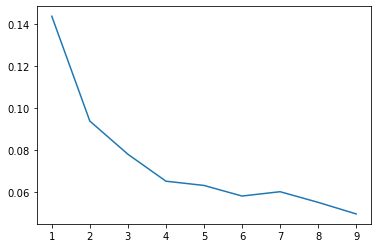

In [147]:
from matplotlib import pyplot as plot 

plot.plot(list(range(1, 10)), nbc_errors)

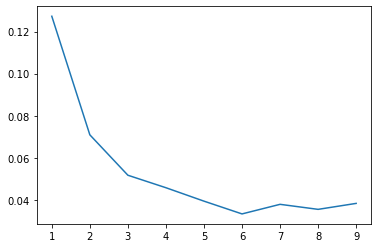

In [161]:
from matplotlib import pyplot as plot 

plot.plot(list(range(1, 10)), lr_errors)